<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_3_Harmonization_And_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

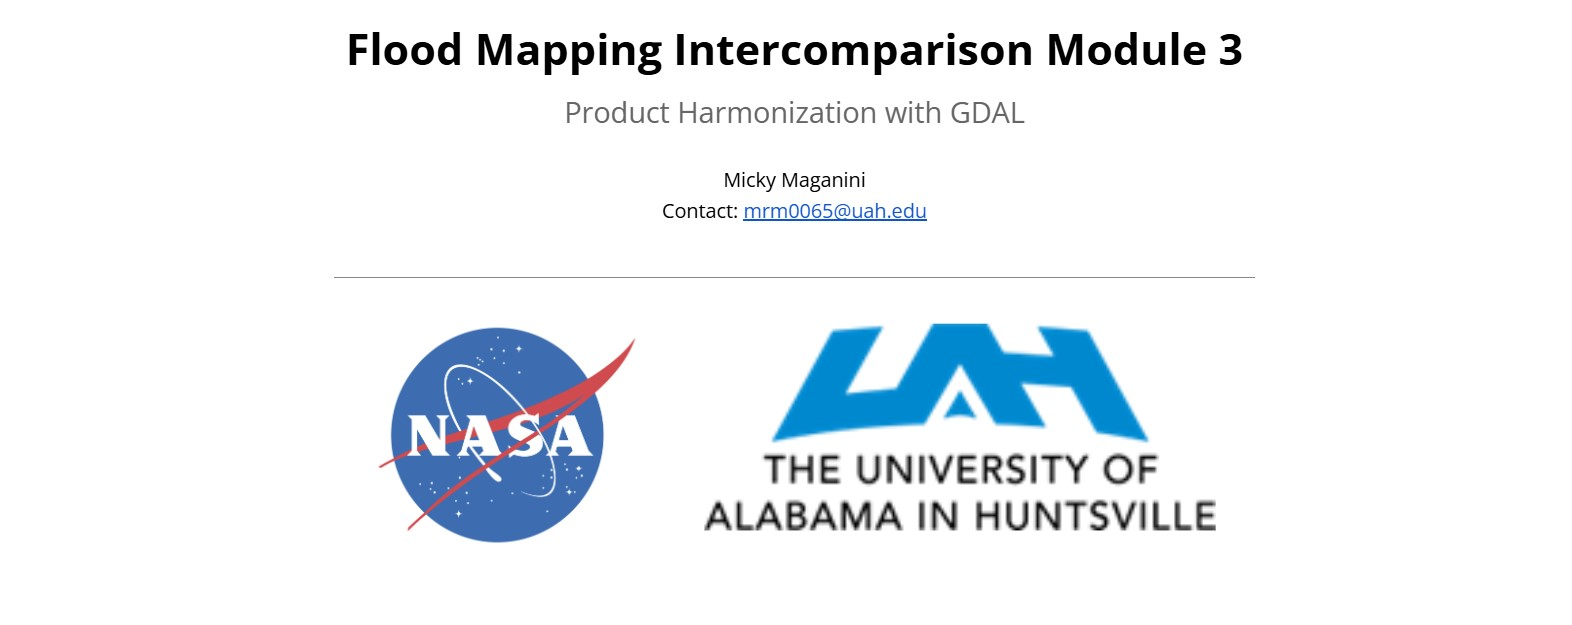

# Introduction

The goal of this module is to take the flood maps that we obtained from the global products, mosaic them, clip them, and assign to them all common raster values.

Each of the products has their own unique raster values, which can be seen in [this table](https://docs.google.com/spreadsheets/d/15igmiH1EHjtiyprgx6LnF78lvNh2scZSnlc12ySr0PQ/edit?usp=sharing). This script will take each product and reassign its raster values to the following raster value scheme:

Pixel Value            |        Land Cover Class
---                    | :---:
0                      |  Nonwater
1                      |  Water
2                      |  Masked (e.g. cloud, cloud shadow)

**Table 1: Pixel Values Used for SERVIR's Flood Mapping Intercomparison Project**

Previously, this manipulation of pixel values was done in Google Earth Engine, but in this module we will attempt to do so using GDAL.

Please be aware that there is a bug affecting the clipping of the flood maps to the region of interest. The bug appears to affect only some regions of interest. If this is affecting you, you can download the "intermediate" flood maps defined later rather than the "harmonized" flood maps.

### MODIFIABLE VARIABLE ALERT

Change the variables below to match your Google Earth Engine project and the Google Earth Engine Folder where you uploaded the flood maps we exported at the end of Module 2.

In [ ]:
my_gdrive_folder = 'drive/My Drive/Flood_Intercomparison/Case_Studies/oct/oct_cambodia'
flood_event_desc = 'oct_cambodia'

In [ ]:
from google.colab import drive
from osgeo import gdal
import os
import glob
import shutil
import numpy as np

In [ ]:
drive.mount('/content/drive/')

# Step 1: Import Imagery

Get imagery from Google Drive

In [ ]:
cd ..

In [ ]:
pwd

In [ ]:
cd content

In [ ]:
os.chdir(my_gdrive_folder)

In [ ]:
ls

we want to duplicate our area of interest file

In [ ]:
mydir = '/content/' + my_gdrive_folder
flood_products = ['dswx_hls', 'dswxs1', 'VFM', 'GFM', 'MCDWD', 'HYDROSAR']

for i in flood_products:
  if i in os.listdir(mydir):
    source_path = glob.glob('drive_export_aoi*')
    stem = source_path[0].split('.')
    src_path = mydir + '/' + source_path[0]
    dst_path = mydir + '/' + i + '/' + stem[0] + '.geojson'
    shutil.copy(src_path, dst_path)

# Step 1: DSWx-HLS

In [ ]:
cd dswx_hls

In [ ]:
input_dswxhls = glob.glob('merged_dswxhls*')[0]
output_dswxhls = f'intermediate_dswxhls_{flood_event_desc}.tif'

in_dswxhls = gdal.Open(input_dswxhls)         # Open the dataset
dswxhls_band = in_dswxhls.GetRasterBand(1)    # Get the first and only band from
dswxhls_data = dswxhls_band.ReadAsArray()     # Read the data as an array so we can manipulate the values

################# Set Nonwater Pixels to 0  ################
# Pixel values of 252 are snow or ice according to dswxhls
dswxhls_data[dswxhls_data == 252] = 0

# Pixel Values of 2 are partial surface water according to dswxhls
# in this study partial surface water will be considered nonwater
dswxhls_data[dswxhls_data == 2] = 0

############# Set Water Pixels to 1 ##################
# Set Ocean Masked pixels to be equal to 1
# Open Water Values are 1 so we do not have to change them
dswxhls_data[dswxhls_data == 254] = 1

###################### Set Masked Pixels to 2 ####################
# Pixel values of 253 are associated with clouds or cloud shadows
dswxhls_data[dswxhls_data == 253] = 2
dswxhls_data[dswxhls_data == 255] = 2

##### Create Output Raster Using The Same Driver and Metadata ##########
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(
    output_dswxhls,
    in_dswxhls.RasterXSize,    # Get the X Size of the Input DSWx-HLS Image
    in_dswxhls.RasterYSize,    # Get the Y Size of the Input DSWx-HLS Image
    1,                         # Get the Number of Bands of the Input DSWx-HLS Image
    dswxhls_band.DataType      # Get the Datatype of the input DSWx-HLS Image
)

# Copy Spatial Metadata
out_ds.SetGeoTransform(in_dswxhls.GetGeoTransform())      # Set the Geotransform of the output to be the same as the input
out_ds.SetProjection(in_dswxhls.GetProjection())          # Set the Projection of the output to be the same as the input

# Write Modified Array
out_band = out_ds.GetRasterBand(1)                        # Get the first band of the output dataset
out_band.WriteArray(dswxhls_data)                         # Write the modified array to the output band

# Clean up
out_band.FlushCache()
in_ds = None
out_ds = None

In [ ]:
inter_dswxhls = f'intermediate_dswxhls_{flood_event_desc}.tif'
final_dswxhls = f'harmonized_dswxhls_{flood_event_desc}.tif'
vector_dswxhls = glob.glob('drive_export*')[0]

gdal.Warp(
    final_dswxhls,
    inter_dswxhls,
    cutlineDSName=vector_dswxhls,
    cropToCutline=True,
    dstNodata = 2
)

# Step 2: DSWx-S1

In [ ]:
# Navigate to the DSWx-S1 Repository
os.chdir('..')
os.chdir('dswxs1')

In [ ]:
input_dswxs1 = glob.glob('merged_dswxs1*')[0]
inter_dswxs1 = f'intermediate_dswxs1_{flood_event_desc}.tif'

in_dswxs1 = gdal.Open(input_dswxs1)            # Open the dataset
dswxs1_band = in_dswxs1.GetRasterBand(1)       # Get the first and only band from the dataset
dswxs1_data = dswxs1_band.ReadAsArray()        # Read the data as an array so we can manipulate the values

################# Set Nonwater Pixels to 0  ################
# Pixel Values of 250 are areas where the height above nearest drainage is higher than the
# threshold set by the DSWX-S1 developers, so they are assumed to be nonwater as it would be
# illogical for water to be found at such a heigh above the nearest drainage.
dswxs1_data[dswxs1_data == 250] = 0
# Nonwater pixels are already set to 0

############### Set Water Pixels to 1 #########################
# DSWx-S1 already has water set to 1 so we don't have to do anything here

###################### Set Masked Pixels to 2 ####################
# Pixel values of 251 are layover or shadow masked
dswxs1_data[dswxs1_data == 251] = 2
# Pixel Values of 255 are no data or fill values
dswxs1_data[dswxs1_data == 255] = 2

##### Create Output Raster Using The Same Driver and Metadata ##########
driver = gdal.GetDriverByName('GTiff')     # Get the GTiff Driver
out_ds = driver.Create(                    # Use the Create method to create the dataset
    inter_dswxs1,
    in_dswxs1.RasterXSize,                 # Get the X Size of the Input DSWx-HLS Image
    in_dswxs1.RasterYSize,                 # Get the Y Size of the Input DSWx-HLS Image
    1,                                     # Get the number of bands of the Input DSWx-HLS Image
    dswxs1_band.DataType                   # Get the Datatype of the input DSWx-HLS Image
)

# Copy Spatial Metadata
out_ds.SetGeoTransform(in_dswxs1.GetGeoTransform())   # Set the geotransform of the output to be the same as the input image
out_ds.SetProjection(in_dswxs1.GetProjection())       # Set the projection of the output to be the same as the input image

# Write Modified Array
out_band = out_ds.GetRasterBand(1)                    # Get the first band of the output dataset
out_band.WriteArray(dswxs1_data)                      # Write the modified array to this band of the output dataset.

# Clean up
out_band.FlushCache()
in_ds = None
out_ds = None

In [ ]:
# Define input and output and vector file path names
inter_dswxs1 = f'intermediate_dswxs1_{flood_event_desc}.tif'
final_dswxs1 = f'harmonized_dswxs1_{flood_event_desc}.tif'
vector_dswxs1 = glob.glob('drive_export*')[0]

# Crop DSWx-S1 map to the area of interest
gdal.Warp(
    final_dswxs1,
    inter_dswxs1,
    cutlineDSName=vector_dswxs1,
    cropToCutline=True,
    dstNodata = 2
)

# Step 3: GFM

GFM has only 0s and 1s, so we do not need to alter the symbology here. But we will clip the image to our area of interest.

In [ ]:
os.chdir('../GFM')

In [ ]:
# Define input and output file paths and area of interest vector files
inter_gfm = f'merged_gfm_{flood_event_desc}.tif'
final_gfm = f'harmonized_gfm_{flood_event_desc}.tif'
vector_gfm = glob.glob('drive_export*')[0]

# Crop harmonized map to area of interest
gdal.Warp(
    final_gfm,
    inter_gfm,
    cutlineDSName=vector_gfm,
    cropToCutline=True,
    dstNodata = 2
)

In [ ]:
ls harm*

# Step 4: HYDRAFloods

HYDRAFloods has only 0s and 1s, so we do not need to alter the symbology here. But we will clip the image to our area of interest.

In [ ]:
os.chdir('..')

In [ ]:
# Define input and output file paths
inter_hydrafloods = f'hydrafloods_{flood_event_desc}.tif'
final_hydrafloods = f'harmonized_hydrafloods_{flood_event_desc}.tif'
vector_hydrafloods = glob.glob('drive_export*')[0]

# Crop hydrafloods map to the area of interest
gdal.Warp(
    final_hydrafloods,
    inter_hydrafloods,
    cutlineDSName=vector_gfm,
    cropToCutline=True,
    dstNodata = 2
)

# Step 5: HYDROSAR

HYDROSAR has only 0s and 1s, so we do not need to alter the symbology here. But we will clip the image to our area of interest.

In [ ]:
os.chdir('HYDROSAR') # Choose the HYDROSAR folder

In [ ]:
# Define file paths for input, output, and area of interest files
inter_hydrosar = f'merged_hydrosar_{flood_event_desc}.tif'
final_hydrosar = f'harmonized_hydrosar_{flood_event_desc}.tif'
vector_hydrosar = glob.glob('drive_export*')[0]

# Crop hydrosar map to the area of interest
gdal.Warp(
    final_hydrosar,
    inter_hydrosar,
    cutlineDSName=vector_hydrosar,
    cropToCutline=True,
    dstNodata = 2
)

# Step 6: MCDWD

More research needed on MCDWD

In [ ]:
# Navigate to the MCDWD directory
os.chdir('..')
os.chdir('MCDWD')

In [ ]:
# Define input and output files
input_mcdwd = glob.glob('merged_mcdwd*')[0]
inter_mcdwd = f'harmonized_mcdwd_{flood_event_desc}.tif'

in_mcdwd = gdal.Open(input_mcdwd)         # Open the file in GDAL
mcdwd_band = in_mcdwd.GetRasterBand(1)    # Get first raster band
mcdwd_data = mcdwd_band.ReadAsArray()     # Read first raster band as array

################# Set Nonwater Pixels to 0  ################
# Nonwater is already set to 0 by the MCDWD algorithm

############### Set Water Pixels to 1 #########################
# Pixel Values of 1 indicate regular surface water according to the MCDWD algorithm
# We do not need to alter these values

# Pixel Values of 2 indicate a recurring flood according to the MCDWD algorithm
mcdwd_data[mcdwd_data == 2] = 1

# Pixel Values of 3 indicate floodwater according to the MCDWD algorithm
mcdwd_data[mcdwd_data == 3] = 1

###################### Set Masked Pixels to 2 ####################
## More research needed on masked pixels, not sure how to access mask value in GDAL. .GetMaskBand() only returns an array of all 255

##### Create Output Raster Using The Same Driver and Metadata ##########
driver = gdal.GetDriverByName('GTiff')     # Get the GTiff Driver
out_ds = driver.Create(                    # Use the Create method to create the dataset
    inter_mcdwd,
    in_mcdwd.RasterXSize,                 # Get the X Size of the Input DSWx-HLS Image
    in_mcdwd.RasterYSize,                 # Get the Y Size of the Input DSWx-HLS Image
    1,                                     # Get the number of bands of the Input DSWx-HLS Image
    mcdwd_band.DataType                   # Get the Datatype of the input DSWx-HLS Image
)

# Copy Spatial Metadata
out_ds.SetGeoTransform(in_mcdwd.GetGeoTransform())   # Set the geotransform of the output to be the same as the input image
out_ds.SetProjection(in_mcdwd.GetProjection())       # Set the projection of the output to be the same as the input image

# Write Modified Array
out_band = out_ds.GetRasterBand(1)                    # Get the first band of the output dataset
out_band.WriteArray(mcdwd_data)                      # Write the modified array to this band of the output dataset.

# Clean up
out_band.FlushCache()
in_ds = None
out_ds = None

# Step 7: VFM

In [ ]:
# Navigate to the VFM Directory
os.chdir('../VFM')

In [ ]:
# Define input and output file paths
input_vfm = glob.glob('merged_vfm*')[0]
inter_vfm = f'harmonized_vfm_{flood_event_desc}.tif'

in_vfm = gdal.Open(input_vfm)        # Open VFM file
vfm_band = in_vfm.GetRasterBand(1)   # Get first raster band
vfm_data = vfm_band.ReadAsArray()    # Read first band as array

################# Set Nonwater Pixels to 0  ################
# Pixel Values of 16 indicate clear-sky bare land
vfm_data[vfm_data == 16] = 0

# Pixel Values of 17 indicate clear-sky vegetation
vfm_data[vfm_data == 17] = 0

# Pixel Values of 20 indicate snow cover
vfm_data[vfm_data == 20] = 0

# Pixel Values of 25 indicate ice
vfm_data[vfm_data == 25] = 0

# Pixel Values of 27 indicate river/lake covered in ice
vfm_data[vfm_data == 27] = 0

# Pixel Values of 38 indicate supra-snow ice water, mixed ice and water, or melting ice
vfm_data[vfm_data == 38] = 0

# Pixel Values between 100 and 150 indicate the relative percentage of a flooded pixel
# that has been identified to be water. 101 corresponds to 1% flooded, 150 corresponds to 50% flooded, etc.
vfm_data[(vfm_data > 100) & (vfm_data < 150)] = 0

###################### Set Masked Pixels to 2 ####################
# Pixel Values of 1 indicate bad data pixels
vfm_data[vfm_data == 1] = 2

# Pixel Values of 30 indicate pixels where there is cloud cover
vfm_data[vfm_data == 30] = 2

# Pixel Values of 50 indicte pixels that have shadows from clouds or terrain
vfm_data[vfm_data == 50] = 2


############### Set Water Pixels to 1 #########################
# Pixel Values of 15 indicate open water without water fraction retrieval
vfm_data[vfm_data == 15] = 1

# Pixel Values of 99 indicate open normal water from a river, lake, reservation, ocean
vfm_data[vfm_data == 99] = 1

# Pixel values greater than 150 indicate a pixel is 50% flooded or more
vfm_data[vfm_data >= 150] = 1

##### Create Output Raster Using The Same Driver and Metadata ##########
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(
    inter_vfm,
    in_vfm.RasterXSize,
    in_vfm.RasterYSize,
    1,
    vfm_band.DataType
)

# Copy Spatial Metadata
out_ds.SetGeoTransform(in_vfm.GetGeoTransform())
out_ds.SetProjection(in_vfm.GetProjection())

# Write Modified Array
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(vfm_data)

# Clean up
out_band.FlushCache()
in_ds = None
out_ds = None

Now all of our flood maps are "harmonized", meaning they all have 0s representing nonwater, 1s representing surface water, and 2s being masked. All of these harmonized flood maps can be found in the Google Drive Folder you defined at the beginning of this notebook. The names of the harmonized files are below. With the exception of HYDRAFloods, each file below belongs to the subdirectory corresponding to the product name within the folder you defined (so the DSWx-HLS harmonized map is located in the DSWx-HLS subfolder). HYDRAFloods will be located in the parent folder.

* DSWx-HLS: 'harmonized_dswxhls_your_event_description.tif'
* DSWx-S1: 'harmonized_dswxhls_your_event_description.tif'
* GFM: 'harmonized_gfm_your_event_description.tif'
* HYDRAFloods: 'hydrafloods_your_event_description.tif'
* HYDROSAR: 'harmonized_hydrosar_your_event_description.tif'
* MCDWD: 'harmonized_mcdwd_your_event_description.tif'
* VFM: 'harmonized_vfm_your_event_description.tif'

You can download these files from your Google Drive folder and pull them into a geospatial program such as QGIS or ArcGIS for further analysis. This is the end of the workflow for simple visualization and analysis of these flood maps. But for scientists or researchers that seek to replicate our flood intercomparison, there are 6 more modules to follow. All of these modules require you to upload your flood maps to Google Earth Engine. To do so, download the above files from Google Drive. Go to the Google Earth Engine Code Editor, click the "New" button in the upper left, then click GeoTiff. Upload each file in the Google Earth Engine folder you defined in Module 1 with the name "x_harmonized", (e.g. dswxhls_harmonized, mcdwd_harmonized). IMPORTANT: MAKE SURE TO CHOOSE THE "MODE" OPTION FOR THE PYRAMIDING POLICY. Once all the flood maps have finished uploading to Google Earth Engine, you can proceed to module 4.

Please be aware that there is a bug affecting the clipping of the flood maps to the region of interest. The bug appears to affect only some regions of interest. If this is affecting you, you can download the "intermediate" flood maps defined later rather than the "harmonized" flood maps.